# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [1]:
# obtain folder already structured
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

--2019-06-05 08:38:21--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.9.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.9.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  64.9MB/s    in 9.1s    

2019-06-05 08:38:35 (60.9 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [2]:
# Unzip data
!unzip /content/Cat_Dog_data.zip

Archive:  /content/Cat_Dog_data.zip
   creating: Cat_Dog_data/
  inflating: Cat_Dog_data/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/Cat_Dog_data/
  inflating: __MACOSX/Cat_Dog_data/._.DS_Store  
   creating: Cat_Dog_data/test/
   creating: Cat_Dog_data/test/cat/
  inflating: Cat_Dog_data/test/cat/cat.7660.jpg  
   creating: __MACOSX/Cat_Dog_data/test/
   creating: __MACOSX/Cat_Dog_data/test/cat/
  inflating: __MACOSX/Cat_Dog_data/test/cat/._cat.7660.jpg  
  inflating: Cat_Dog_data/test/cat/cat.1211.jpg  
  inflating: __MACOSX/Cat_Dog_data/test/cat/._cat.1211.jpg  
  inflating: Cat_Dog_data/test/cat/cat.1563.jpg  
  inflating: __MACOSX/Cat_Dog_data/test/cat/._cat.1563.jpg  
  inflating: Cat_Dog_data/test/cat/cat.1205.jpg  
  inflating: __MACOSX/Cat_Dog_data/test/cat/._cat.1205.jpg  
  inflating: Cat_Dog_data/test/cat/cat.7884.jpg  
  inflating: __MACOSX/Cat_Dog_data/test/cat/._cat.7884.jpg  
  inflating: Cat_Dog_data/test/cat/cat.6542.jpg  
  inflating: __MACOSX/Cat_Dog_da

In [0]:
!mkdir /content/cat-dogs
!mv /content/Cat_Dog_data/* /content/cat-dogs/

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [0]:
data_dir = 'cat-dogs'

# Defining transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.transforms.RandomGrayscale(p=0.15),
                                transforms.RandomHorizontalFlip(p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [19]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 83270015.40it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 512)),
                          ('relu1', nn.ReLU(True)),
                          ('dropout', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 256)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(256, 2)),
                          ('relu3', nn.ReLU()),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [0]:
import time

In [17]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 12.976 seconds
Device = cuda; Time per batch: 0.010 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [22]:
## Set the Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Set the model to be trained with the device (cpu or cuda)
model.to(device)
## Use the pre-trained network to Classify between dogs and cats
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 5
steps = 0
print_every = 5 

train_losses, test_losses = [], []
for e in range(epochs):
    print("Epoch {}".format(e))
    running_loss = 0
    for images, labels in trainloader:
      steps += 1
      images, labels = images.to(device), labels.to(device)
      # clear the gradients
      optimizer.zero_grad()

      # Apply forward step  
      log_ps = model.forward(images)
      # Calculate the loss using NLLLoss
      loss = criterion(log_ps, labels)
      # Update the weights with the backward step
      loss.backward()
      # Apply the Adam Optimizer (https://arxiv.org/pdf/1412.6980.pdf)
      optimizer.step()
        
      running_loss += loss.item()
    
      if steps % print_every == 0:
        # initialize on every step
        test_loss = 0 
        accuracy = 0
        model.eval()

        ## TODO: Implement the validation pass and print out the validation accuracy
        with torch.no_grad():
          # set the model to evaluation
          for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)
            
            # get probabilities 
            ps = torch.exp(log_ps)
            # get top class predicted 
            top_p, top_class = ps.topk(1, dim=1)
            # get which class were predicted correctly 
            correct_preds = top_class == labels.view(*top_class.shape)
            # calculate the accuracy 
            accuracy += torch.mean(correct_preds.type(torch.torch.FloatTensor)).item()
              
        # set model back to training
        model.train()
        
        # add values for the train losses and validation loss 
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print(f'Accuracy: {(accuracy/len(testloader))*100}%')
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]))


Epoch 0
Accuracy: 96.7578125%
Epoch: 1/5..  Training Loss: 0.008..  Test Loss: 0.368.. 
Accuracy: 97.96875%
Epoch: 1/5..  Training Loss: 0.012..  Test Loss: 0.084.. 
Accuracy: 92.03125%
Epoch: 1/5..  Training Loss: 0.015..  Test Loss: 0.183.. 
Accuracy: 96.2890625%
Epoch: 1/5..  Training Loss: 0.018..  Test Loss: 0.088.. 
Accuracy: 97.1875%
Epoch: 1/5..  Training Loss: 0.021..  Test Loss: 0.076.. 
Accuracy: 95.859375%
Epoch: 1/5..  Training Loss: 0.023..  Test Loss: 0.095.. 
Accuracy: 97.8515625%
Epoch: 1/5..  Training Loss: 0.024..  Test Loss: 0.061.. 
Accuracy: 98.28125%
Epoch: 1/5..  Training Loss: 0.025..  Test Loss: 0.051.. 
Accuracy: 97.890625%
Epoch: 1/5..  Training Loss: 0.026..  Test Loss: 0.055.. 
Accuracy: 97.8515625%
Epoch: 1/5..  Training Loss: 0.027..  Test Loss: 0.059.. 
Accuracy: 98.2421875%
Epoch: 1/5..  Training Loss: 0.028..  Test Loss: 0.052.. 
Accuracy: 98.1640625%
Epoch: 1/5..  Training Loss: 0.029..  Test Loss: 0.046.. 
Accuracy: 98.0859375%
Epoch: 1/5..  Trainin

In [0]:
# create the checkpoint dict
checkpoint = {'input_size': 1024,
              'output_size': 2,
              'state_dict': model.state_dict(),
              'architecture': models.densenet121(pretrained=True),
              'classifier': model.classifier,
              'batch_size': 64,
              'epochs': 5,
              'class_to_idx': train_data.class_to_idx}

# Saving the model 
torch.save(checkpoint, 'checkpoint_cat_dogs.pth')

In [0]:
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.cuda()
    # let us process the image 
    img = process_image(image_path)
    # Convert 2D image to 1D vector
    image = img.unsqueeze_(0)

    # Calculate the class probabilities (softmax) for img
    with torch.no_grad():
      model.eval()
      output = model.forward(image.cuda())
      possibilities, predicted = torch.topk(output, topk)
    
    ps = F.softmax(possibilities,dim=1)
    
    return ps, predicted

In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['architecture']
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    epochs = checkpoint['epochs']
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']

    return model

In [33]:
model_densenet = load_checkpoint('checkpoint_cat_dogs.pth')
model_densenet.classifier
idx_to_class = { v : k for k,v in model_densenet.class_to_idx.items()}


{0: 'cat', 1: 'dog'}

In [0]:
cat_to_name = {'cat': 'cat', 'dog': 'dog'}

In [0]:
def update_labels(classes):
  labels = []
  
  for x in classes.cpu().numpy():
    for y in x:
      labels.append(cat_to_name[idx_to_class[y]])

  return labels

In [0]:
def process_image(img_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(img_path)
    
    transform = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    image_tensor = transform(img)
    
    return image_tensor

In [0]:
def check(img, ps, classes):
    ps = ps.data.numpy().squeeze()
    
    img = Image.open(img)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    
    ax2.set_yticklabels(np.arange(2))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    ax2.set_yticklabels(update_labels(classes))

    plt.tight_layout()

In [47]:
import PIL
from PIL import Image
print(PIL.PILLOW_VERSION)
import numpy as np

4.3.0


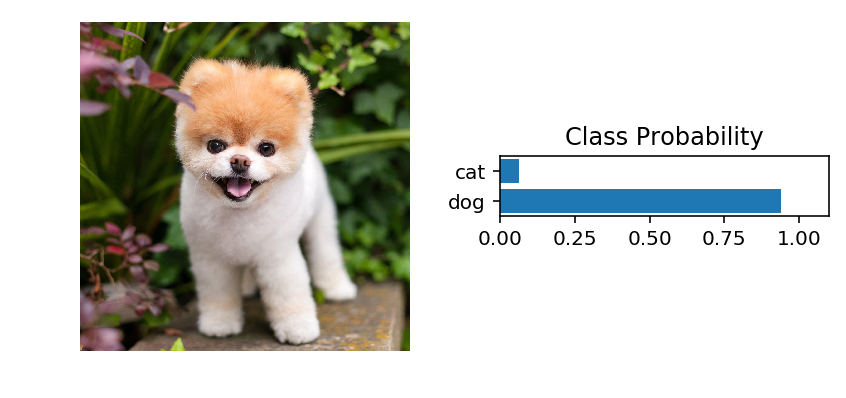

In [71]:
img_path = "/content/cat-dogs/001.jpg" 
probs, preds = predict(img_path,model_densenet)
check(img_path, probs.cpu(), preds.cpu())
